# EasyVVUQ and Cloud Execution via Kubernetes

**Author**: Vytautas Jancauskas, LRZ (jancauskas@lrz.de)

To run code examples in this tutorial you will want to download it first and run it on a Jupyter notebook server running locally. That is because the examples assume you have configured access to a Kubernetes cluster. So if you are viewing this in our Binder you will want to instead open the copy of this tutorial that is located in the EasyVVUQ source code under ```tutorials/kubernetes``` And then you will want to open that notebook in your local Jupyter instance.

This tutorial assumes that you have access to a Kubernetes cluster. Like the ones provided by Google or Amazon. The next thing you need to do is to build a Docker container for your application. I have found that most online resources don't explain it adequately in the context relevant to us so I will outline the required steps here.

First thing you need is a Dockerfile that instructs what needs to be done to set-up the environment, build and install the software etc. Here is the Dockerfile we made for EasyVVUQ. Yours will look different but I hope you will see that it is fairly straightforward. For further information please consult [this](https://docs.docker.com/develop/develop-images/dockerfile_best-practices/).

In [1]:
!cat kubernetes/Dockerfile

FROM ubuntu:latest

RUN apt-get update && \
    apt-get install -y python3-pip && \
    apt-get install -y git && \
    apt-get install -y tini && \
    pip3 install easyvvuq && \
    git clone https://github.com/UCL-CCS/EasyVVUQ.git

ENTRYPOINT ["tini", "--"]


You will need to register for an account on [DockerHub](https://hub.docker.com/). Or if you don't want your Docker image to be publicly accessible you need to look into private registries, for example [here](https://cloud.google.com/container-registry/docs/quickstart), but this will usually be provider specific. Then you need to build your container, login to DockerHub and push the image. After that it will be accessible to run in your Kubernetes cluster.

```docker build -t user/imagename:tag .```

```docker login```

```docker push user/imagename:tag```

In order for the code examples below to work you need to have a valid ```~/.kube/config``` file. Details will differ based on your provider, but in the case of Google Cloud you can do it as shown below. Here ```easyvvuq``` is a cluster name. It is created from a cluster template. Again, this will be provider specific, consult their documentation.

In [2]:
!gcloud container clusters create easyvvuq

Creating cluster easyvvuq in us-central1-f... Cluster is being health-checked..
.⠏                                                                             
Creating cluster easyvvuq in us-central1-f... Cluster is being health-checked (
master is healthy)...done.                                                     
Created [https://container.googleapis.com/v1/projects/graphite-flare-278712/zones/us-central1-f/clusters/easyvvuq].
To inspect the contents of your cluster, go to: https://console.cloud.google.com/kubernetes/workload_/gcloud/us-central1-f/easyvvuq?project=graphite-flare-278712
kubeconfig entry generated for easyvvuq.
NAME      LOCATION       MASTER_VERSION   MASTER_IP      MACHINE_TYPE  NODE_VERSION     NUM_NODES  STATUS
easyvvuq  us-central1-f  1.17.15-gke.800  35.238.138.25  e2-medium     1.17.15-gke.800  3          RUNNING


We will not go in to detail for most of this code since this is the same as the [other](./vector_qoi_tutorial.ipynb) example. Only the differences will be explained.

In [3]:
import easyvvuq as uq
import chaospy as cp
import matplotlib.pyplot as plt

In [4]:
params = {
    "S0": {"type": "float", "default": 997}, 
    "I0": {"type": "float", "default": 3}, 
    "beta": {"type": "float", "default": 0.2}, 
    "gamma": {"type": "float", "default": 0.04, "min": 0.0, "max": 1.0},
    "iterations": {"type": "integer", "default": 100},
    "outfile": {"type": "string", "default": "output.csv"}
}

In [5]:
encoder = uq.encoders.GenericEncoder(template_fname='sir.template', delimiter='$', target_filename='input.json')
decoder = uq.decoders.SimpleCSV(target_filename='output.csv', output_columns=['I'])

In [6]:
campaign = uq.Campaign(name='sir', params=params, encoder=encoder, decoder=decoder)

In [7]:
vary = {
    "beta": cp.Uniform(0.15, 0.25),
    "gamma": cp.Normal(0.04, 0.01),
}

In [8]:
campaign.set_sampler(uq.sampling.PCESampler(vary=vary, polynomial_order=5))

The only difference between this example and the one where we run the simulation locally is the type of action we pass to ```sample_and_apply```. In this case we use ```ExecuteKubernetes```. In the simple case we have here it is enough to specify the image to be pulled from DockerHub and a way to run the simulation. The input configuration is automatically transferred to the Kubernetes pod using the Kubernetes API. Likewise the results are retrieved from standard output of the pod. This output is sent directly to the Decoder. Which might mean you will want to exercise some care when designing decoders for these cases. In this case there is nothing special to be done. If your simulation produces a lot of data you might have to use a script inside the container to extract the quantities of interest and print them to ```stdout```.

The second argument to ```ExecuteKubernetes``` is the command to be executed inside the running container. If you look at the way we have created the Docker image, EasyVVUQ is cloned to the root directory, which means the path to the simulation code is ```/EasyVVUQ/tutorials/sir```. We run the ```sir``` simulation and then we print the ```output.csv``` file to ```stdout``` using the ```cat``` command. It will be picked up by our Kubernetes backend.

In [9]:
execution = campaign.sample_and_apply(
    action=uq.actions.ExecuteKubernetes(
        "orbitfold/easyvvuq:latest",
        "/EasyVVUQ/tutorials/sir /config/input.json && cat output.csv"), 
    batch_size=8).start()

In [20]:
execution.progress()

{'ready': 0, 'active': 0, 'finished': 36, 'failed': 0}

The remaining steps are exactly the same as we would have in the case of local execution.

In [21]:
result = campaign.analyse(qoi_cols=['I'])

<AxesSubplot:xlabel='t', ylabel='First Order Sobol Index'>

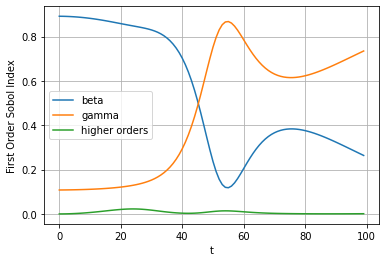

In [22]:
result.plot_sobols_first('I', xlabel='t')

<AxesSubplot:xlabel='t', ylabel='I'>

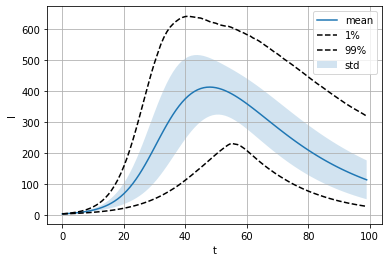

In [23]:
result.plot_moments('I', xlabel='t')